# Calculating correlation and skill score on C3S seasonal forecasts
This notebook shows an example workflow on how to compute correlation and probabilistic skill scores with open source Python tools. 
This notebook has three sections:

1.   How to prepare the environment
2.   How to download the data from the CDS
3.   The calculation of the scores

This notebook has the aim to show the potentiality of a xarray-based workflow starting from the CDS data. The metrics shown are calculated in a naive way, without applying bias correction or any type of calibration.

**Important note**: to download the files from the Copernicus Data Store (CDS) you need to use your API key ([see here](https://cds.climate.copernicus.eu/api-how-to))



## 1. Preparing the environment
### 1.1 ecCodes and cartopy with apt
The ECMWF ecCodes binary library is needed by `cfgrib` and the `cartopy` module is useful for maps.

In [1]:
!apt-get -qq install -y libeccodes0 python-cartopy python3-cartopy

Selecting previously unselected package libeccodes-data.
(Reading database ... 131183 files and directories currently installed.)
Preparing to unpack .../00-libeccodes-data_2.6.0-2_all.deb ...
Unpacking libeccodes-data (2.6.0-2) ...
Selecting previously unselected package libeccodes0:amd64.
Preparing to unpack .../01-libeccodes0_2.6.0-2_amd64.deb ...
Unpacking libeccodes0:amd64 (2.6.0-2) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../02-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-pyshp.
Preparing to unpack .../03-python-pyshp_1.2.12+ds-1_all.deb ...
Unpacking python-pyshp (1.2.12+ds-1) ...
Selecting previously unselected package python-shapely.
Preparing to unpack .../04-python-shapely_1.6.4-1_amd64.deb ...
Unpacking python-shapely (1.6.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../05-python-six_1.11.0-2_all.deb ...

### 1.2 Installing Anaconda
The module `esmpy` is not available via pip and will be installed from the `conda-forge` channel. All the other modules (except `cdsapi`) will be installed as well via anaconda. We follow the steps suggested in https://rjai.me/posts/google-colab-conda/

In [2]:
!wget https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh && bash Miniconda3-4.5.4-Linux-x86_64.sh -bfp /usr/local


--2019-10-12 11:30:24--  https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58468498 (56M) [application/x-sh]
Saving to: ‘Miniconda3-4.5.4-Linux-x86_64.sh’

Miniconda3-4.5.4-Li 100%[===================>]  55.76M   116MB/s    in 0.5s    

2019-10-12 11:30:24 (116 MB/s) - ‘Miniconda3-4.5.4-Linux-x86_64.sh’ saved [58468498/58468498]

PREFIX=/usr/local
installing: python-3.6.5-hc3d631a_2 ...
Python 3.6.5 :: Anaconda, Inc.
installing: ca-certificates-2018.03.07-0 ...
installing: conda-env-2.6.0-h36134e3_1 ...
installing: libgcc-ng-7.2.0-hdf63c60_3 ...
installing: libstdcxx-ng-7.2.0-hdf63c60_3 ...
installing: libffi-3.2.1-hd88cf55_4 ...
installing: ncurses-6.1-hf484d3e_0 ...
installing: openssl-1.0.2o-h20670df_0 ...
installing: tk-

In [3]:
!conda install -y -q --prefix /usr/local -c conda-forge esmpy xesmf

Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs: 
    - esmpy
    - xesmf


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    libnetcdf-4.6.2            |    h303dfb8_1003         1.3 MB  conda-forge
    python-3.7.3               |       h33d41f4_1        36.0 MB  conda-forge
    libffi-3.2.1               |    he1b5a44_1006          46 KB  conda-forge
    mpich-3.3.1                |       hc856adb_1         6.4 MB  conda-forge
    hdf5-1.10.5                |nompi_h3c11f04_1103         3.1 MB  conda-forge
    numpy-1.17.2               |   py37h95a1406_0         5.2 MB  conda-forge
    libcblas-3.8.0             |      13_openblas          10 KB  conda-forge
    mpi-1.0                    |            mpich           4 KB  conda-forge
    krb5-1.16.3                |    h05b26f9_1001         1.4 MB  conda-forge
   

In [0]:
import sys
sys.path.append('/usr/local/lib/python3.6/site-packages')
sys.path.append('/usr/local/lib/python3.7/site-packages')

### 1.3 Installing cdsapi with pip

In [5]:
!pip install cdsapi cfgrib xskillscore

     |████████████████████████████████| 51kB 4.8MB/s 
     |████████████████████████████████| 61kB 25.0MB/s 
     |████████████████████████████████| 61kB 26.4MB/s 
     |████████████████████████████████| 81kB 7.5MB/s 
     |████████████████████████████████| 440kB 59.3MB/s 
     |████████████████████████████████| 40kB 19.7MB/s 
     |████████████████████████████████| 3.6MB 55.7MB/s 
     |████████████████████████████████| 6.7MB 41.7MB/s 
     |████████████████████████████████| 112kB 49.1MB/s 
     |████████████████████████████████| 768kB 45.1MB/s 
     |████████████████████████████████| 143kB 47.6MB/s 
     |████████████████████████████████| 61kB 24.2MB/s 
     |████████████████████████████████| 133kB 58.1MB/s 
     |████████████████████████████████| 163kB 56.7MB/s 
     |████████████████████████████████| 20.2MB 1.3MB/s 
     |████████████████████████████████| 296kB 43.6MB/s 
  Created wheel for cdsapi: filename=cdsapi-0.2.3-py2.py3-none-any.whl size=11252 sha256=c0f72cc45e9e8ae0d68b474

## 2. Load the data
Let's start importing all the needed Python modules. 

In [0]:
import xarray as xr             # to open and manipulate data arrays 
import xskillscore as xs        # calculating skill scores
import cfgrib                   # to open GRIB files
import xesmf as xe              # regridding
import numpy as np
      
import os
import os.path
from pathlib import Path

In [0]:
# Plot and mapping
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
# Increase the size of the output figures
plt.rcParams["figure.figsize"] = (16,8)


In [0]:
# To minimise the warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### 2.1 Setting up the request for the CDS
If you don't have an account on the [Copernicus Data Store](https://cds.climate.copernicus.eu/#!/home) you need to [register and install the API](https://cds.climate.copernicus.eu/api-how-to)

**Important**: don't forget to insert your key in the following chunk of code

In [0]:
!echo "url: https://cds.climate.copernicus.eu/api/v2" > $HOME/.cdsapirc
!echo "key: INSERT-HERE-YOUR-KEY" >> $HOME/.cdsapirc

In [0]:
import cdsapi

In [0]:
# create a new client
c = cdsapi.Client()

### 2.2 Download climate data: seasonal forecasts
From the CDS you can download the [C3S Seasonal Forecasts](https://climate.copernicus.eu/seasonal-forecasts)

Let's define a list of the models and of the variables available

In [0]:
MODELS = [
    {'centre': 'ecmwf', 'name': 'ECMWF', 'system': '5', 'start_year': 1993, 'end_year': 2016},
    {'centre': 'ukmo', 'name': 'UKMO', 'system': '14', 'start_year': 1993, 'end_year': 2016},
    {'centre': 'meteo_france', 'name': 'MF', 'system': '6', 'start_year': 1993, 'end_year': 2016},
    {'centre': 'dwd', 'name': 'DWD', 'system': '2', 'start_year': 1993, 'end_year': 2016},
    {'centre': 'cmcc', 'name': 'CMCC', 'system': '3', 'start_year': 1993, 'end_year': 2016}
]

VARS = [
    {'source': 'seasonal-monthly-single-levels', 'short_name': 'mslp', 'var': 'mean_sea_level_pressure', 'pressure_level': None, 'xarray_var':'msl'},
    {'source': 'seasonal-monthly-single-levels', 'short_name': 'u10', 'var': '10m_u_component_of_wind', 'pressure_level': None, 'xarray_var':'u10'},
    {'source': 'seasonal-monthly-single-levels', 'short_name': 'ws', 'var': '10m_wind_speed', 'pressure_level': None, 'xarray_var':'ws10'},
    {'source': 'seasonal-monthly-single-levels', 'short_name': 't2m', 'var': '2m_temperature', 'pressure_level': None, 'xarray_var':'t2m'},
    {'source': 'seasonal-monthly-single-levels', 'short_name': 'prec', 'var': 'total_precipitation', 'pressure_level': None, 'xarray_var':'tp'},
    {'source': 'seasonal-monthly-single-levels', 'short_name': 'ssr', 'var': 'surface_solar_radiation', 'pressure_level': None, 'xarray_var':'ssr'}
]

Now we select the starting month of the forecast, the model (selected from the `MODELS` dictionary) and the variable (from `VARS`)

In [0]:
START_MONTH = 6
M  = MODELS[0]
V  = VARS[3]

Now we can prepare the dictionary containing the request for the CDS API. We will download the monthly seasonal forecast from the starting month for the next 4 months (from M+0 to M+3)

In [42]:
request_dict = {
                'originating_centre': M['centre'],
                'variable':V['var'],
                'product_type':'monthly_mean',
                'year':[x for x in map(str, range(M['start_year'], M['end_year']))],
                'month': str(START_MONTH),
                'leadtime_month':[
                    '1', '2','3','4'
                ],
                'format':'grib',
                'system': M['system']
            }
print(request_dict)

{'originating_centre': 'ecmwf', 'variable': '2m_temperature', 'product_type': 'monthly_mean', 'year': ['1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015'], 'month': '6', 'leadtime_month': ['1', '2', '3', '4'], 'format': 'grib', 'system': '5'}


The request is sent and the file downloaded if not already present. The download from the CDS **may take up to one hour**

In [43]:
seasonal_target_filename = M['name']+'-'+V['short_name']+'-'+'S'+str(START_MONTH)+'-L1-4.grib'

if not Path(seasonal_target_filename).exists():
    print('Downloading ' + seasonal_target_filename)
    c.retrieve(
                V['source'],
                request_dict,
                seasonal_target_filename)
else:
    print('Using the file ' + seasonal_target_filename + ' already downloaded')

2019-10-12 13:13:11,643 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/seasonal-monthly-single-levels


2019-10-12 13:13:12,696 INFO Request is queued
2019-10-12 13:19:32,407 INFO Request is running
2019-10-12 13:21:32,906 INFO Request is completed
2019-10-12 13:21:32,907 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data4/adaptor.mars.external-1570886272.142091-4775-7-daf67756-ff56-4e30-ac73-4c63ecad33ec.grib to ECMWF-t2m-S6-L1-4.grib (286.4M)
2019-10-12 13:21:59,949 INFO Download rate 10.6M/s


### 2.3 Download ERA5
Now we download the ERA5 data for the verification. 

In [68]:
request_dict = {
                'variable':V['var'],
                'product_type':'monthly_averaged_reanalysis',
                'year':[x for x in map(str, range(M['start_year'], M['end_year']))],
                'month': [x for x in map(str, range(START_MONTH+1, START_MONTH+3+1))],
                'format':'grib',
                'time': '00:00'
            }
print(request_dict)

{'variable': '2m_temperature', 'product_type': 'monthly_averaged_reanalysis', 'year': ['1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015'], 'month': ['7', '8', '9'], 'format': 'grib', 'time': '00:00'}


In [69]:
era5_target_filename = 'era5-monthly-'+V['short_name']+'-'+str(M['start_year'])+'-'+str(M['end_year'])+'-'+'S'+str(START_MONTH)+'-L1-4.grib'
if not Path(era5_target_filename).exists():
    print('Downloading ' + era5_target_filename)
    c.retrieve(
                'reanalysis-era5-single-levels-monthly-means',
                request_dict,
                era5_target_filename)
else:
    print('Using the ERA5 file ' + era5_target_filename + ' already downloaded')

2019-10-12 14:44:20,956 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means


2019-10-12 14:44:21,479 INFO Request is queued
2019-10-12 14:44:22,587 INFO Request is running
2019-10-12 14:44:54,424 INFO Request is completed
2019-10-12 14:44:54,426 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data3/adaptor.mars.internal-1570891462.1812394-26665-1-715cc25a-1e08-44b8-8880-ca33d9bcbcb9.grib to era5-monthly-t2m-1993-2016-S6-L1-4.grib (136.6M)
2019-10-12 14:45:01,498 INFO Download rate 19.3M/s


### 2.4 Regrid and compute
We regrid seasonal forecasts and reanalysis on the same grid. For the seasonal forecasts (`ftc`) we also compute the ensemble mean (`fct_final_ensmean`)

In [0]:
# Defining the grid
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-89, 89, 1)),
                     'lon': (['lon'], np.arange(0, 360, 1))})

In [74]:
fct = xr.open_dataset(seasonal_target_filename, engine='cfgrib').isel(step = slice(1,4)).mean(dim = 'step').rename({'latitude':'lat', 'longitude': 'lon'})

2019-10-12 14:46:49,529 INFO missing from GRIB stream: 'directionNumber'
2019-10-12 14:46:49,531 INFO missing from GRIB stream: 'frequencyNumber'


In [48]:
regridder = xe.Regridder(fct, ds_out, 'bilinear')

Create weight file: bilinear_181x360_178x360.nc


In [49]:
fct_final = regridder(fct)

using dimensions ('lat', 'lon') from data variable t2m as the horizontal dimensions for this dataset.


In [0]:
fct_final_ensmean = fct_final.mean('number')

In [51]:
fct_final_ensmean

<xarray.Dataset>
Dimensions:  (lat: 178, lon: 360, time: 23)
Coordinates:
  * time     (time) datetime64[ns] 1993-06-01 1994-06-01 ... 2015-06-01
    surface  int64 ...
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * lat      (lat) int64 -89 -88 -87 -86 -85 -84 -83 ... 82 83 84 85 86 87 88
Data variables:
    t2m      (time, lat, lon) float64 220.3 220.3 220.3 ... 271.5 271.5 271.5

In [75]:
obs = xr.open_dataset(era5_target_filename, engine = 'cfgrib')

2019-10-12 14:46:59,840 INFO missing from GRIB stream: 'directionNumber'
2019-10-12 14:46:59,842 INFO missing from GRIB stream: 'frequencyNumber'


In [0]:
obs_y = obs.groupby('time.year').mean('time').rename({'latitude':'lat', 'longitude': 'lon'})

In [77]:
# REGRIDDING 1 DEGREE (OBS)
regridder = xe.Regridder(obs_y, ds_out, 'bilinear')

Overwrite existing file: bilinear_721x1440_178x360.nc 
 You can set reuse_weights=True to save computing time.


In [78]:
obs_final = regridder(obs_y).rename({'year':'time'})

using dimensions ('lat', 'lon') from data variable t2m as the horizontal dimensions for this dataset.


In [79]:
obs_final['time'] = fct.time # this is needed because xskillscore expects 
print(obs_final)


<xarray.Dataset>
Dimensions:  (lat: 178, lon: 360, time: 23)
Coordinates:
    number   int64 0
    step     timedelta64[ns] 00:00:00
    surface  int64 0
  * time     (time) datetime64[ns] 1993-06-01 1994-06-01 ... 2015-06-01
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * lat      (lat) int64 -89 -88 -87 -86 -85 -84 -83 ... 82 83 84 85 86 87 88
Data variables:
    t2m      (time, lat, lon) float64 217.2 217.2 217.2 ... 270.7 270.7 270.7
Attributes:
    regrid_method:  bilinear


## 3. Calculating metrics and skill scores
We compute in order:

1.    Pearson correlation between observations and ensemble mean
2.    Continuous Ranked Probability score (CRPS)
3.    Brier Skill Score for the upper tercile

All the skill scores are computed using `xskillscore` which uses `properscoring` for the probabilistic ones. 

In [0]:
r = xs.pearson_r(obs_final, fct_final_ensmean, "time")

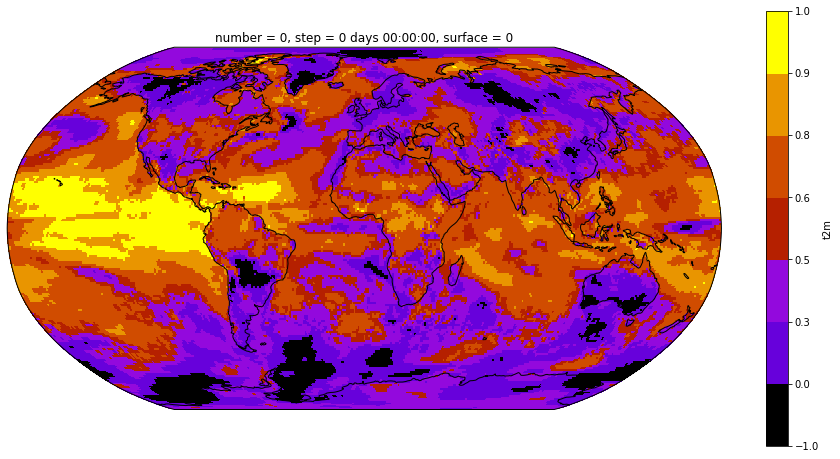

In [81]:
ax = plt.axes(projection=ccrs.Robinson())
p = r[V['xarray_var']].plot(ax=ax, transform=ccrs.PlateCarree(), levels = [-1, 0, 0.3, 0.5, 0.6, 0.8, 0.9, 1], cmap = 'gnuplot')
ax.set_global(); ax.coastlines();

In [0]:
crps_ensemble = xs.crps_ensemble(obs_final, fct_final.rename({'number':'member'}))

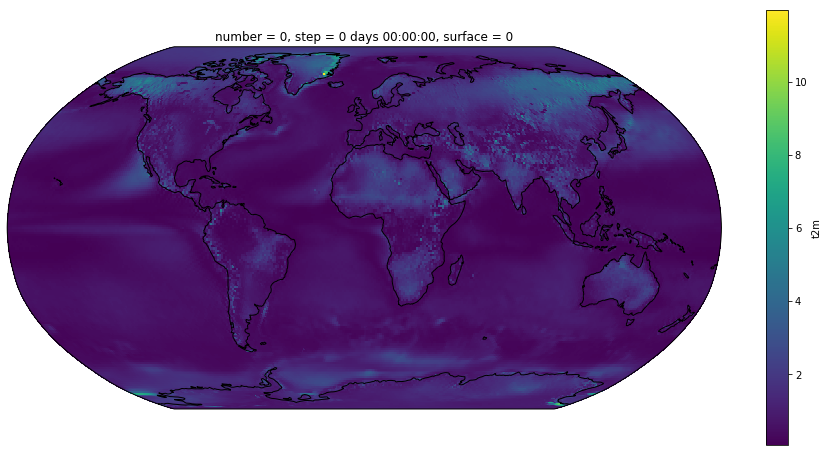

In [63]:
ax = plt.axes(projection=ccrs.Robinson())
crps_ensemble[V['xarray_var']].mean('time').plot(ax=ax, transform=ccrs.PlateCarree())
ax.set_global(); ax.coastlines();

In [0]:
brier_score = xs.brier_score(obs_final >  obs_final.quantile(2/3, dim = 'time'), (fct_final > fct_final.quantile(2/3, dim = 'time')).mean("number"))


In [0]:
baseline = xs.brier_score(obs_final >  obs_final.quantile(2/3, dim = 'time'), 2/3)

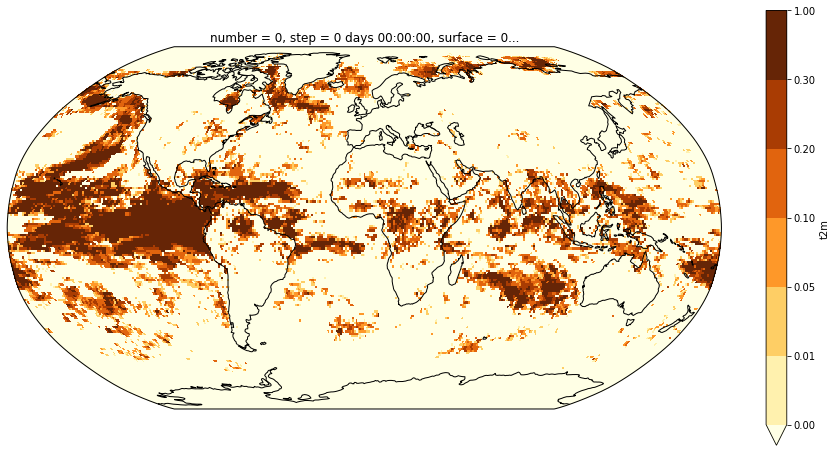

In [84]:
#ax = plt.axes(projection=ccrs.Orthographic(20, 35))
ax = plt.axes(projection=ccrs.Robinson())
(1 - (brier_score/baseline)).mean(dim = 'time')[V['xarray_var']].plot(ax=ax, transform=ccrs.PlateCarree(), levels = [0, 0.01, 0.05, 0.1, 0.2, 0.3,  1], cmap = 'YlOrBr')
ax.set_global(); ax.coastlines();